In [1]:
GPU = False  #set to True to use GPU for XGboost and LightGBM

### Baseline Models

Simple If-Then Models

 - Team with best record wins (Accuracy = 0.56, AUC = 0.58 on Test data)
 - Home team always wins (Accuracy = 0.55, AUC = 0.50 on Test data)
 - Home team wins unless they have losing home record (Accuracy = 0.59, AUC = 0.57 on Test data)
 - Home team wins unless they have lost last 3 home games (Accuracy = 0.59, AUC = 0.55 on Test data)
 
ML Models

 - LightGBM (Accuracy = 0.59, AUC = 0.62 on Test data)
 - XGBoost (Accuracy = 0.56, AUC = 0.57 on Test data)
    

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
print('XGB version:', xgb.__version__)

import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
print('LGB version:', lgb.__version__)

from tqdm import tqdm

import shap

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')


XGB version: 1.6.2
LGB version: 3.3.3


In [3]:
train = pd.read_csv(DATAPATH / "train.csv")
test = pd.read_csv(DATAPATH / "test.csv")

train.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PLAYOFF,CONFERENCE_x,G_x,W_x,L_x,W_PCT_x,HOME_W_x,HOME_L_x,HOME_W_PCT_x,ROAD_W_x,ROAD_L_x,ROAD_W_PCT_x,CONFERENCE_y,G_y,W_y,L_y,W_PCT_y,HOME_W_y,HOME_L_y,HOME_W_PCT_y,ROAD_W_y,ROAD_L_y,ROAD_W_PCT_y,TARGET,HOME_WINS_LAST_3_HOME,PTS_home_LAST_3_HOME,AWAY_WINS_LAST_3_AWAY,PTS_away_LAST_3_AWAY
0,2003-10-29,20300006,1610612740,1610612737,2003,88.0,0.324,0.700,0.160,24.0,55.0,83.0,0.398,0.737,0.214,18.0,58.0,1,0,0,1,1,0,1.00,1,0,1.000000,0,0,NaN,0,1,0,1,0.000,0,0,NaN,0,1,0.0,1.0,1.0,91.666667,NaN,NaN
1,2003-10-31,20300024,1610612741,1610612737,2003,100.0,0.400,0.759,0.500,27.0,53.0,94.0,0.400,0.714,0.583,22.0,48.0,1,0,0,2,1,1,0.50,1,1,0.500000,0,0,NaN,0,2,0,2,0.000,0,0,NaN,0,2,0.0,0.0,1.0,88.666667,NaN,NaN
2,2003-11-05,20300060,1610612744,1610612737,2003,99.0,0.446,0.645,0.278,23.0,52.0,72.0,0.367,0.500,0.333,19.0,43.0,1,0,1,4,2,2,0.50,2,1,0.666667,0,1,0.0,0,5,1,4,0.200,1,1,0.5,0,3,0.0,1.0,2.0,96.666667,0.0,83.0
3,2003-11-08,20300084,1610612757,1610612737,2003,90.0,0.425,0.900,0.500,28.0,41.0,83.0,0.438,0.786,0.100,21.0,45.0,1,0,1,6,3,3,0.50,3,1,0.750000,0,2,0.0,0,6,1,5,0.167,1,1,0.5,0,4,0.0,1.0,2.0,88.666667,0.0,83.0
4,2003-11-09,20300089,1610612760,1610612737,2003,81.0,0.379,0.737,0.056,12.0,46.0,91.0,0.479,0.789,0.533,16.0,41.0,0,0,1,4,3,1,0.75,2,1,0.666667,1,0,1.0,0,7,2,5,0.286,1,1,0.5,1,4,0.2,0.0,2.0,96.666667,1.0,82.0


**Model - Team with best record wins**

In [4]:
# train data
predict = (train['W_PCT_x'] > train['W_PCT_y']).astype('int8')
true =  train['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5725690979303163, 0.5752392109878647)

In [5]:
# test data
predict = (test['W_PCT_x'] > test['W_PCT_y']).astype('int8')
true =  test['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5574257425742575, 0.5574603174603174)

**Model - Home team always wins**

In [6]:
# train data
n = train.shape[0]
predict = pd.Series(1, index=range(n))
true =  train['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5928320388770772, 0.5)

In [7]:
# test data
n = test.shape[0]
predict = pd.Series(1, index=range(n))
true =  test['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5544554455445545, 0.5)

**Model - Home team wins unless they have a losing home record**

In [8]:
# train data
predict = train['HOME_W_PCT_x'].apply(lambda x: 0 if x < 0.50 else 1)
true =  train['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.6245932225452336, 0.5856594049716664)

In [9]:
# test data
predict = test['HOME_W_PCT_x'].apply(lambda x: 0 if x < 0.50 else 1)
true =  test['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.5881188118811881, 0.570952380952381)

**Model - Home team wins unless Home team has lost last three home games**

In [11]:
# train data
predict = train['HOME_WINS_LAST_3_HOME'].apply(lambda x: 0 if x < 1 else 1)
true =  train['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.603939775241897, 0.5304273590587807)

In [12]:
# test data
predict = test['HOME_WINS_LAST_3_HOME'].apply(lambda x: 0 if x < 1 else 1)
true =  test['TARGET']

accuracy_score(true,predict), roc_auc_score(true,predict)

(0.593069306930693, 0.5549007936507937)

### ML Baseline Models

**Fix Datatypes for smaller memory footprint**

In [13]:
def fix_datatypes(df):
    df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df

train = fix_datatypes(train)
test = fix_datatypes(test)


**Select Features**

In [14]:
target = train['TARGET']
test_target = test['TARGET']

category_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS', 'PLAYOFF', 'CONFERENCE_x', 'CONFERENCE_y',]

all_columns = train.columns.tolist()
drop_columns = ['TARGET', 'GAME_DATE_EST', 'GAME_ID'] #not really useful as-is

use_columns = [item for item in all_columns if item not in drop_columns]

train = train[use_columns]
test = test[use_columns]

**Options**

In [15]:
K_FOLDS = 5
SEED = 13

### LightGBM


In [16]:
%%time

NUM_BOOST_ROUND = 700
EARLY_STOPPING = 200
LOG_EVALUATION = 100

train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
#train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
test_preds_shap = 0

lgb_params= {
            'seed': SEED,
            'verbose': 0,           
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc', 
            #'num_leaves': 31,
            #'learning_rate': 0.05,
            #'feature_fraction': 0.9,
            #'bagging_fraction': 0.8,
            #'bagging_freq': 5,

            }

gpu_params= {
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
             }

if GPU:
    lgb_params = lgb_params | gpu_params
    

# K-fold cross validation

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_lgbdataset = lgb.Dataset(train_df, label=train_target,)
    val_lgbdataset = lgb.Dataset(val_df, label=val_target, reference = train_lgbdataset )

    model =  lgb.train(lgb_params, 
                       train_lgbdataset,
                       valid_sets=val_lgbdataset,
                       num_boost_round = NUM_BOOST_ROUND,
                       callbacks=[log_evaluation(LOG_EVALUATION),early_stopping(EARLY_STOPPING,verbose=False)],
                       #verbose_eval= VERBOSE_EVAL,
                      )

    temp_oof = model.predict(val_df)
    temp_oof_shap = model.predict(val_df, pred_contrib=True)
    
    temp_test = model.predict(test)
    temp_test_shap = model.predict(test, pred_contrib=True)

    train_oof[val_ind] = temp_oof
    test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    test_preds_shap += temp_test_shap/K_FOLDS
    

    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:",accuracy_score(target, train_oof_binary))
print("AUC Score:", roc_auc_score(target, train_oof))
print("Optimal Threshold:", optimal_threshold)

#scores for Test data

test_preds_binary = (test_preds > optimal_threshold).astype(int)
print()
print("Test data Scores:")
print()
print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
print("AUC Score:", roc_auc_score(test_target, test_preds))





0it [00:00, ?it/s]

[100]	valid_0's auc: 0.634534


1it [00:01,  1.16s/it]

[200]	valid_0's auc: 0.621573
0.617353579175705 0.6479647224933482
[100]	valid_0's auc: 0.641887


2it [00:02,  1.06s/it]

[200]	valid_0's auc: 0.631713
0.6119305856832972 0.6535277604120673
[100]	valid_0's auc: 0.618806
[200]	valid_0's auc: 0.610514


3it [00:03,  1.07s/it]

0.5910175743111304 0.6290214678528324
[100]	valid_0's auc: 0.632423


4it [00:04,  1.01s/it]

[200]	valid_0's auc: 0.621832
0.6229116945107399 0.6479833906790298
[100]	valid_0's auc: 0.644942


5it [00:05,  1.02s/it]

[200]	valid_0's auc: 0.636501
0.6157517899761337 0.6532436655171526

Composite Train OOF CV Scores:

Accuracy Score: 0.6138759925369897
AUC Score: 0.6424464654262241
Optimal Threshold: 0.5959543961473022

Test data Scores:

Accuracy Score: 0.5910891089108911
AUC Score: 0.6183849206349207
CPU times: total: 1min 32s
Wall time: 5.09 s


**Feature Importance via Split - the number of times a feature is used in the model**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

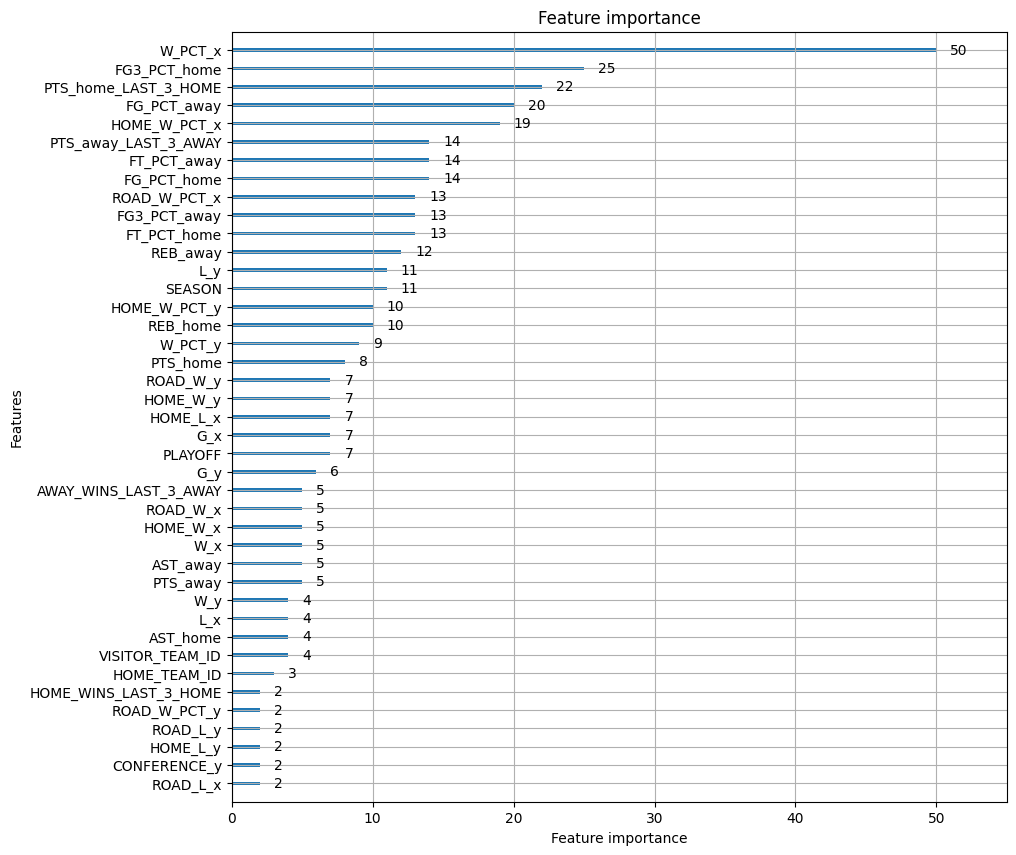

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lgb.plot_importance(model, importance_type='split', ax=ax)

**Feature Importance via Gain - the average gain of splits which use the feature**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

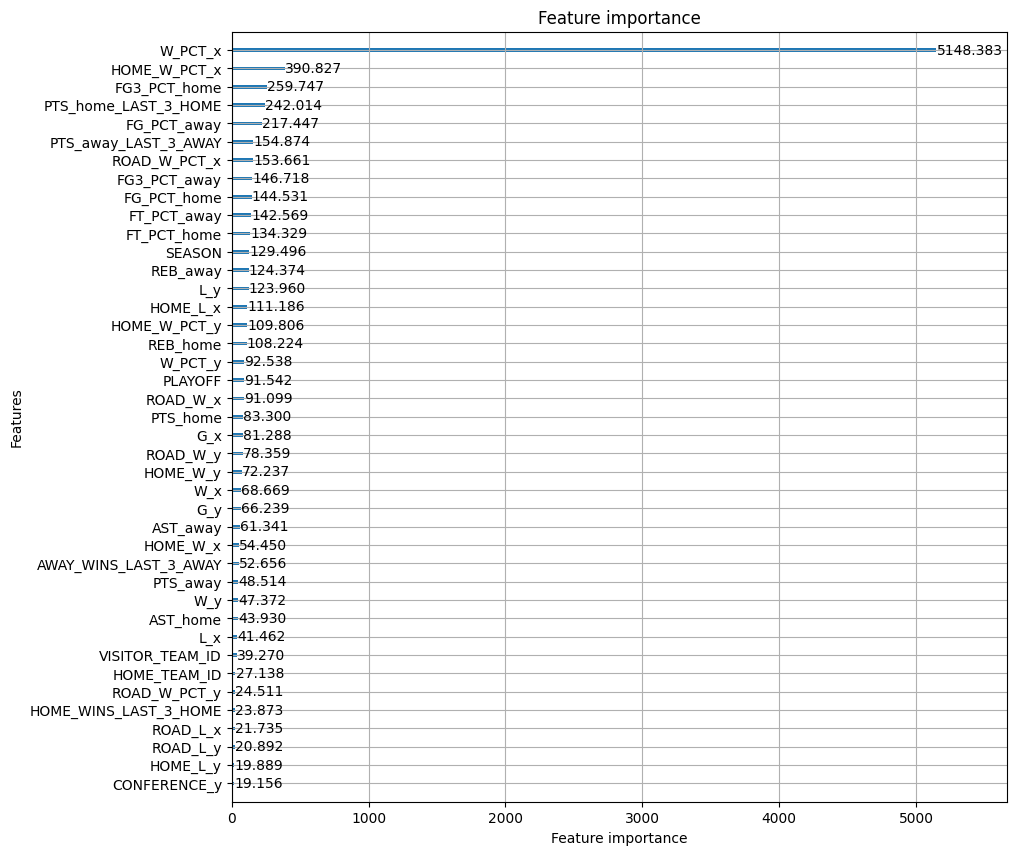

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
lgb.plot_importance(model, importance_type='gain', ax=ax)

**Feature Importance via Shapley values**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


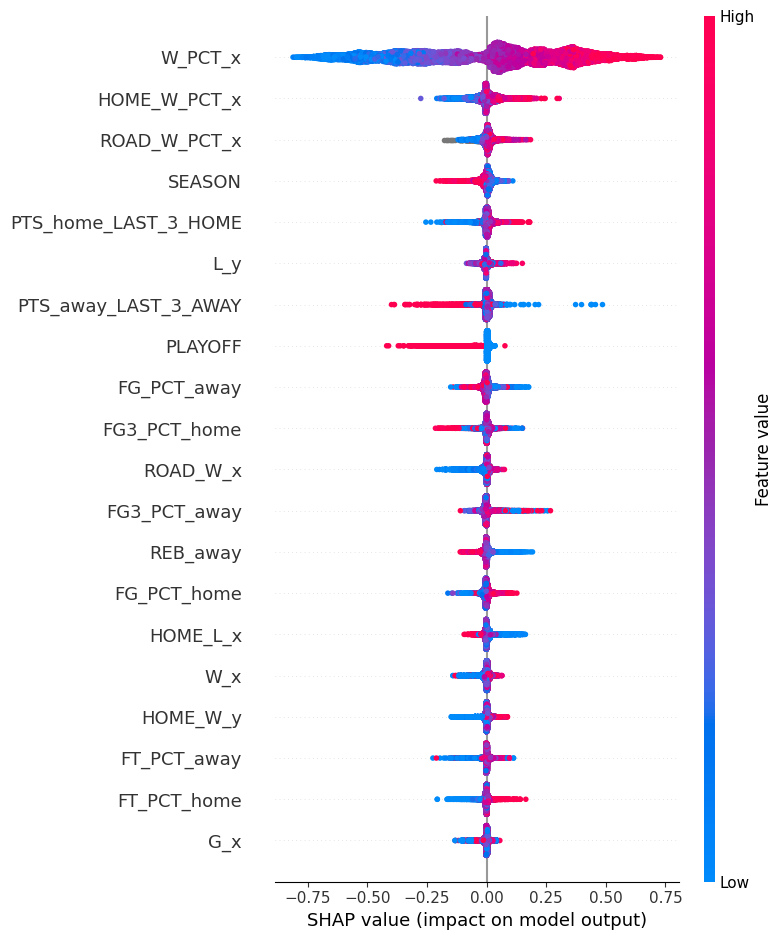

In [19]:
# summarize the effects of all the features
shap.summary_plot(train_oof_shap[:,:-1], train)

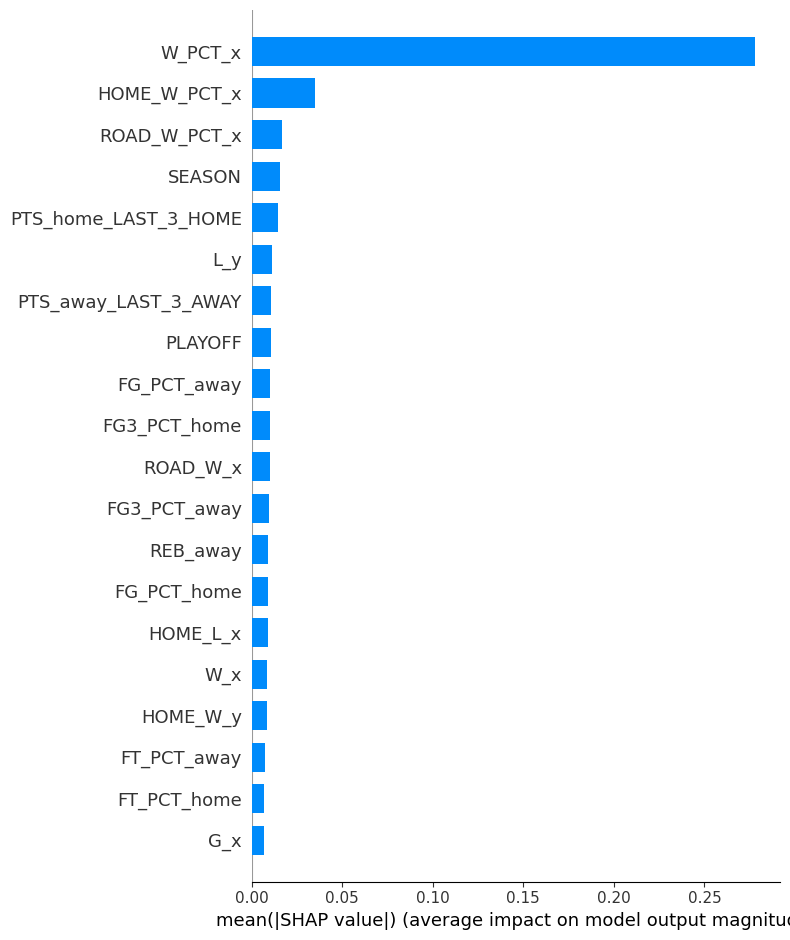

In [20]:
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")

### XGBoost


In [21]:
%%time

NUM_BOOST_ROUND = 700

train_oof = np.zeros((train.shape[0],))
test_preds = 0
train_oof_shap = np.zeros((train.shape[0],train.shape[1]+1))
train_oof_shap_interact = np.zeros((train.shape[0],train.shape[1]+1,train.shape[1]+1))
test_preds_shap = 0

xgb_params= {
            'seed': SEED,
            'eval_metric': 'auc',
             #'max_bin': 168, 
             #'max_depth': 1, #16
             #'alpha': 6.956941489832698, 
             #'gamma': 0.6029881527116713, 
             #'reg_lambda': 2.527966510426255, 
             #'colsample_bytree': 0.9087064850010729, 
             #'subsample': 0.31410604106509005, 
             #'min_child_weight': 7.877326540625619,
             #'num_parallel_tree' : 10,
             #'learning_rate': 0.03,  
            }

gpu_params= {
             'tree_method': 'gpu_hist',
             'predictor': 'gpu_predictor',
             }

if GPU:
    xgb_params = xgb_params | gpu_params
    

# K-fold cross validation

test_dmatrix = xgb.DMatrix(test)

kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train, target))):
    
    train_df, val_df = train.iloc[train_ind], train.iloc[val_ind]
    train_target, val_target = target[train_ind], target[val_ind]

    train_dmatrix = xgb.DMatrix(train_df, label=train_target)
    val_dmatrix = xgb.DMatrix(val_df, label=val_target)

    model =  xgb.train(xgb_params, 
                       train_dmatrix, 
                       num_boost_round = NUM_BOOST_ROUND,
                      )

    temp_oof = model.predict(val_dmatrix)
    temp_oof_shap = model.predict(val_dmatrix, pred_contribs=True)
    temp_oof_shap_interact = model.predict(val_dmatrix, pred_interactions=True)
    
    temp_test = model.predict(test_dmatrix)
    temp_test_shap = model.predict(test_dmatrix, pred_contribs=True)

    train_oof[val_ind] = temp_oof
    test_preds += temp_test/K_FOLDS

    train_oof_shap[val_ind, :] = temp_oof_shap
    train_oof_shap_interact[val_ind, :,:] = temp_oof_shap_interact
    test_preds_shap += temp_test_shap/K_FOLDS
    
    #for accuracy score, prediction probabilities must be convert to binary scores (Win or Lose)
    #determine optimum threshold for conveting probablities using ROC curve
    #generally 0.5 works for balanced data
    #fpr = false positive rate, tpr = true postive rate
    fpr, tpr, thresholds = roc_curve(val_target,temp_oof)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    temp_oof_binary = (temp_oof > optimal_threshold).astype(int)

    print(accuracy_score(val_target, temp_oof_binary), roc_auc_score(val_target, temp_oof))
    

    
# Out-of-Fold composite for train data

fpr, tpr, thresholds = roc_curve(target,train_oof)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
train_oof_binary = (train_oof > optimal_threshold).astype(int)

print()
print("Composite Train OOF CV Scores:")
print()
print("Accuracy Score:",accuracy_score(target, train_oof_binary))
print("AUC Score:", roc_auc_score(target, train_oof))
print("Optimal Threshold:", optimal_threshold)

#scores for Test data

test_preds_binary = (test_preds > optimal_threshold).astype(int)
print()
print("Test data Scores:")
print()
print("Accuracy Score:",accuracy_score(test_target, test_preds_binary))
print("AUC Score:", roc_auc_score(test_target, test_preds))



1it [00:06,  6.51s/it]

0.5707158351409979 0.5821219410114271


2it [00:12,  6.46s/it]

0.5431670281995662 0.591049313224328


3it [00:19,  6.43s/it]

0.5745280972011282 0.5619353054392456


4it [00:25,  6.44s/it]

0.5612931221523106 0.573660618522283


5it [00:32,  6.42s/it]

0.5918854415274463 0.5821182637007593

Composite Train OOF CV Scores:

Accuracy Score: 0.5675792944851824
AUC Score: 0.5781953016338548
Optimal Threshold: 0.5499593019485474

Test data Scores:

Accuracy Score: 0.5554455445544555
AUC Score: 0.5727777777777777
CPU times: total: 39.4 s
Wall time: 32.1 s


**Feature Importance via Weight - the number of times a feature appears in a tree**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

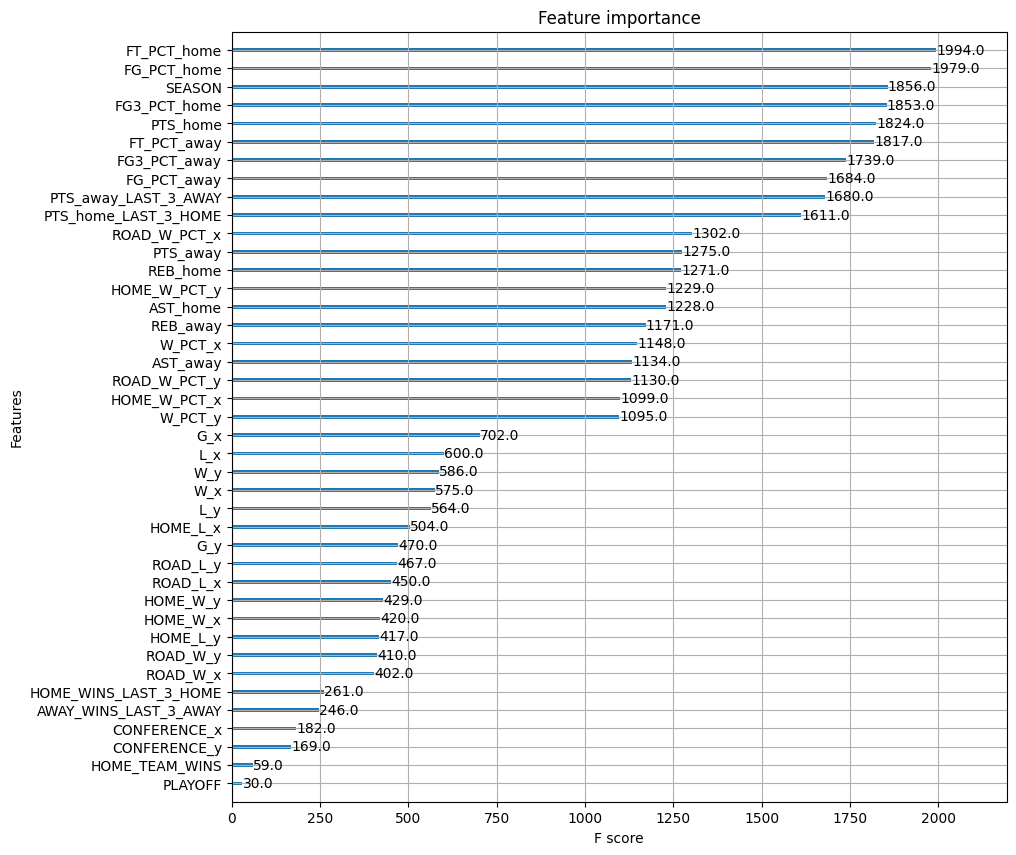

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='weight', ax=ax)

**Feature Importance via Gain - the average gain of splits which use the feature**

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

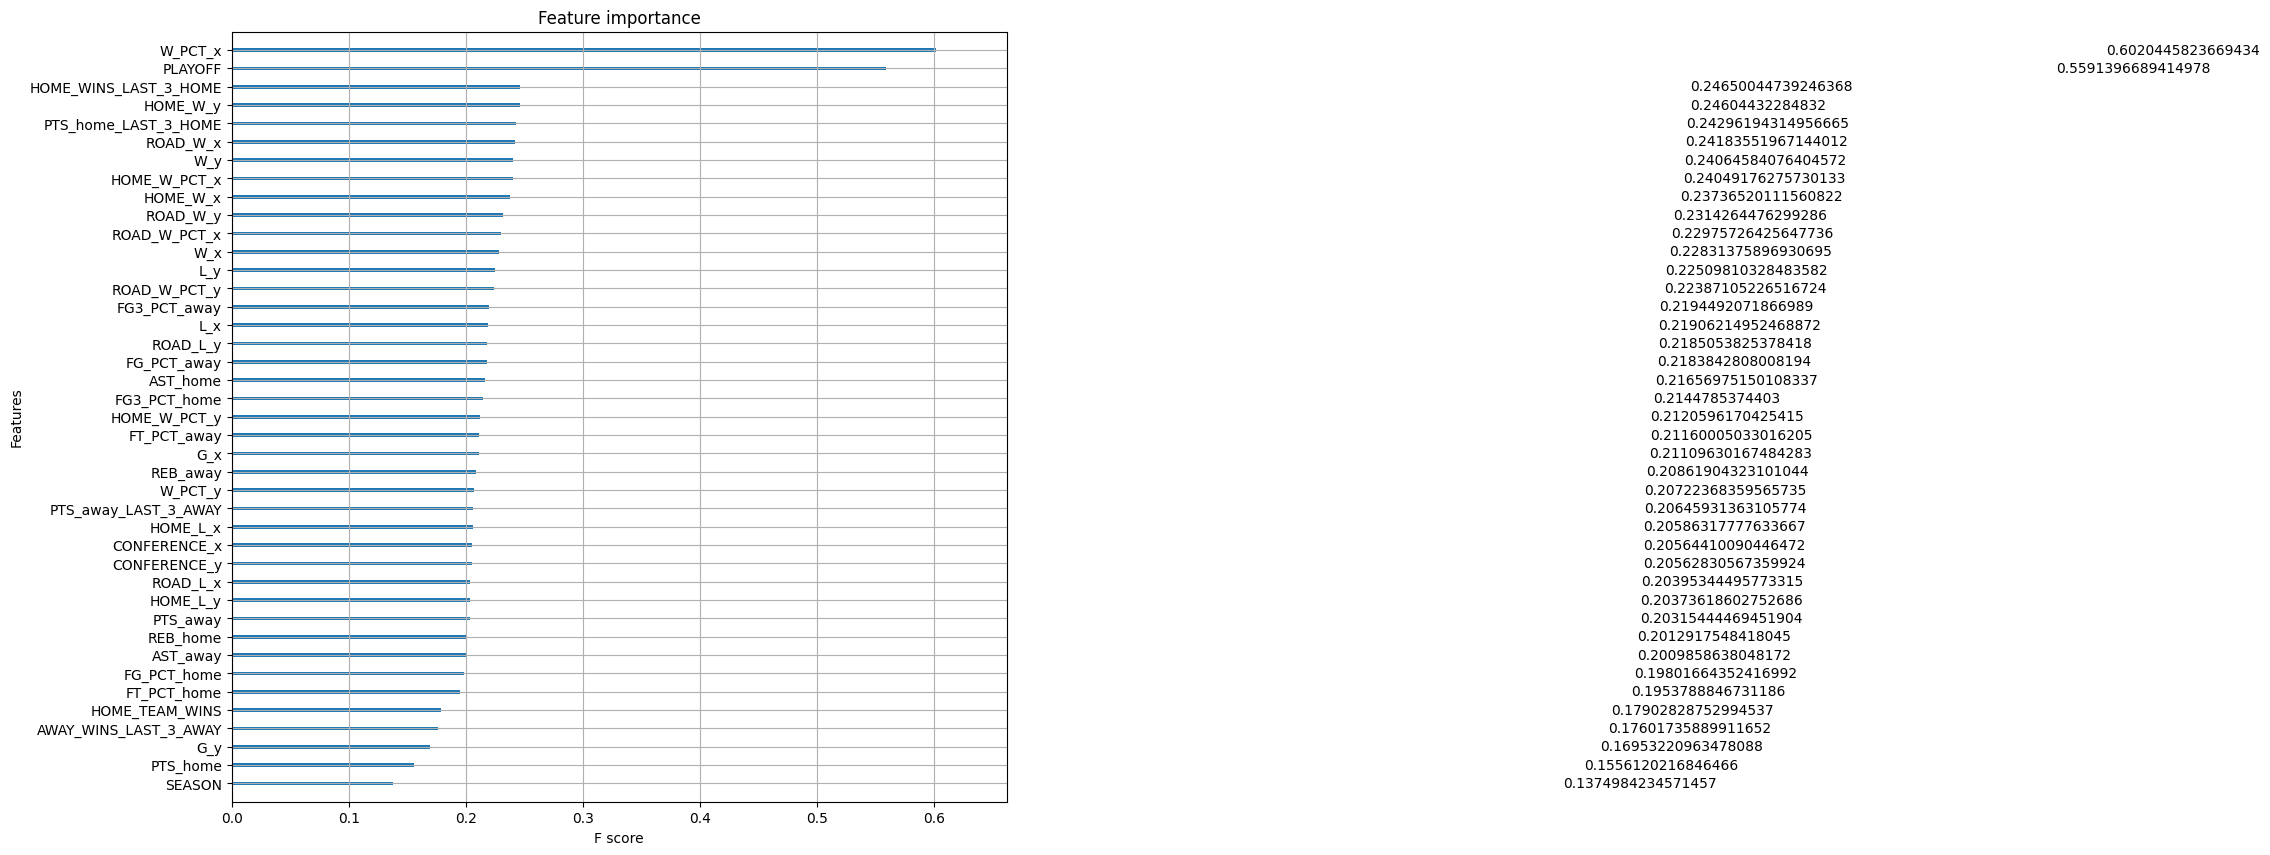

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(model, importance_type='gain', ax=ax)

**Feature Importance via Shapley values**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


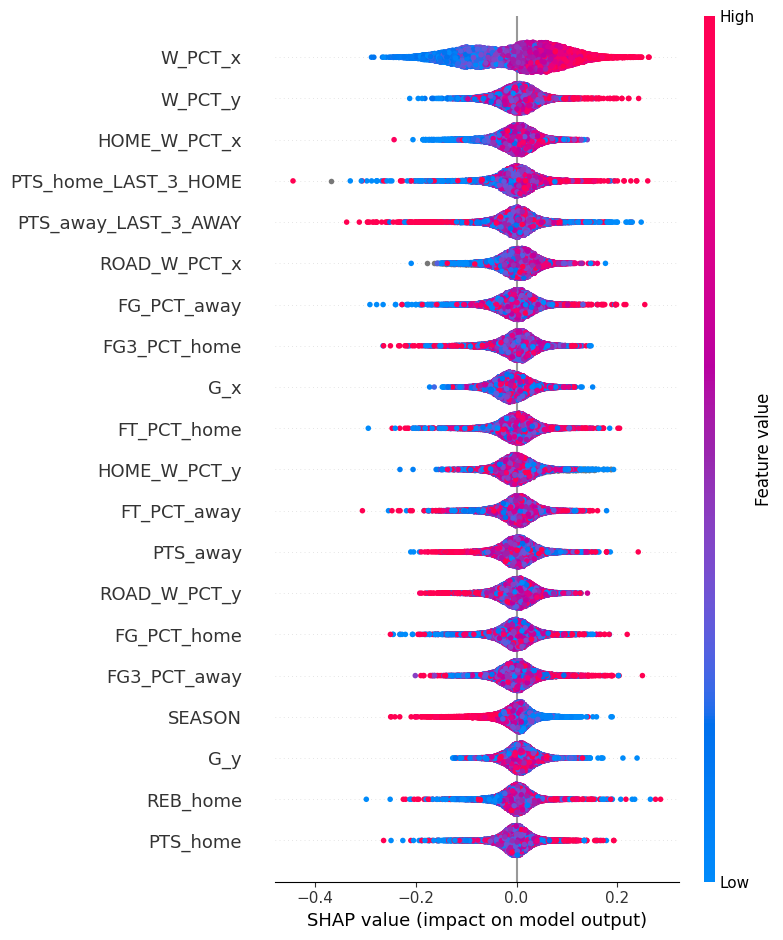

In [24]:
# summarize the effects of all the features
shap.summary_plot(train_oof_shap[:,:-1], train)

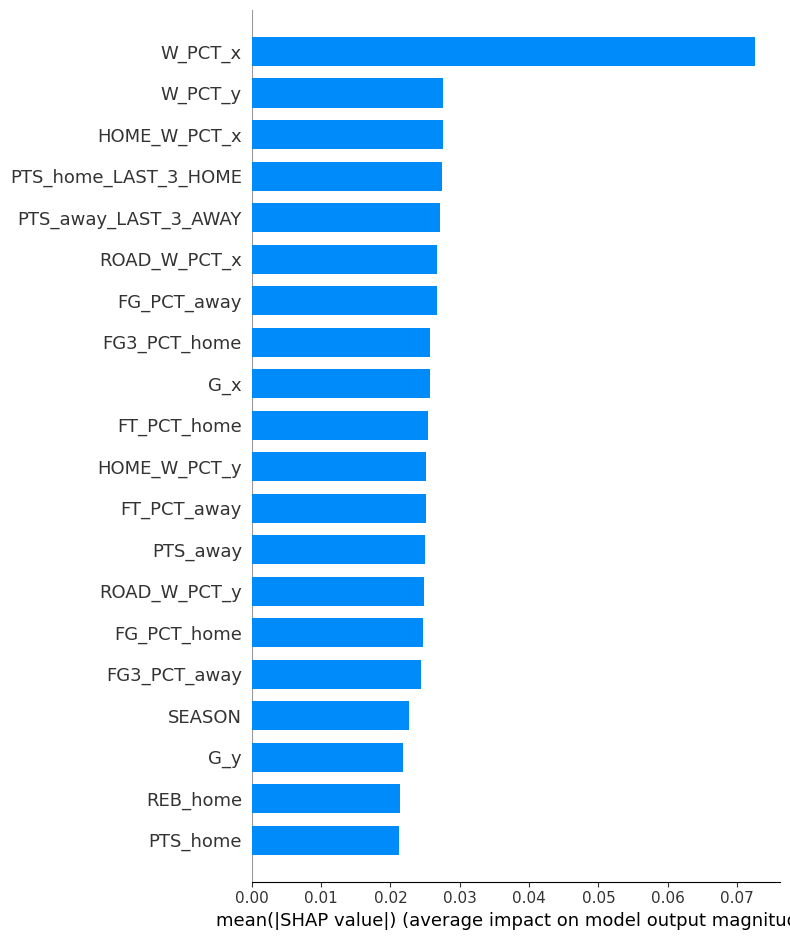

In [25]:
shap.summary_plot(train_oof_shap[:,:-1], train[use_columns], plot_type="bar")